# Part A: Basic Prescriptive Analytics

In [10]:
# imports 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, avg, hour, count, round
from pyspark.sql.types import TimestampType
from shapely.geometry import Point
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Data Ingestion**

In [2]:
# a) initialize spark session
spark = SparkSession.builder.appName("NYC Taxi Data").getOrCreate()

# b) load dataset
df = spark.read.format("csv").option("header", "true").load("yellow_tripdata_2015-01.csv")

**Initial Data Exploration**

In [3]:
# a) schema
df.count()
df.show(5)
df.columns
df.printSchema()
df.describe().show()

# b) basic stats
df.select("trip_distance", "passenger_count", "fare_amount").describe().show()

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|   -73.993896484375|40.750110626220703|        

**Data Cleaning**

In [4]:
# a) handle missing values
df = df.dropna(subset=["fare_amount", "trip_distance", "passenger_count"])

# b) filter out rows w/ invalid data
df = df.filter((col("fare_amount") >= 0) & (col("trip_distance") > 0))

# c) convert `pickup_datetime` and `dropoff_datetime` to timestamp 
df = df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType())) \
       .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast(TimestampType()))

# d) create new columns (trip duration in min, trip speed in mph)
## trip duration in min
df = df.withColumn("trip_duration", 
                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

## trip speed in mph
df = df.withColumn("trip_speed_mph", 
                   col("trip_distance") / (col("trip_duration") / 60))

## display
df.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "trip_duration", "trip_speed_mph").show()

+--------------------+---------------------+-------------+------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|     trip_duration|    trip_speed_mph|
+--------------------+---------------------+-------------+------------------+------------------+
| 2015-01-15 19:05:39|  2015-01-15 19:23:42|         1.59|             18.05| 5.285318559556787|
| 2015-01-10 20:33:38|  2015-01-10 20:53:28|         3.30|19.833333333333332| 9.983193277310924|
| 2015-01-10 20:33:38|  2015-01-10 20:43:41|         1.80|             10.05|10.746268656716417|
| 2015-01-10 20:33:39|  2015-01-10 20:52:58|         3.00|19.316666666666666| 9.318377911993098|
| 2015-01-10 20:33:39|  2015-01-10 20:53:52|         9.00|20.216666666666665|26.710634789777412|
| 2015-01-10 20:33:39|  2015-01-10 20:58:31|         2.20|24.866666666666667|5.3083109919571045|
| 2015-01-10 20:33:39|  2015-01-10 21:11:35|        18.20| 37.93333333333333|28.787346221441126|
| 2015-01-10 20:33:41|  2015-0

**Exploratory Data Analysis**

In [5]:
# a) calculate avg fare and avg trip distance grouped by num of passengers
df.groupBy("passenger_count") \
  .agg(avg("fare_amount").alias("avg_fare"), avg("trip_distance").alias("avg_trip_distance")) \
  .orderBy("passenger_count") \
  .show()

# b) busiest times of day for taxi pickup
df.groupBy(hour("tpep_pickup_datetime").alias("hour")) \
  .agg(count("*").alias("pickup_count")) \
  .orderBy("pickup_count", ascending=False) \
  .show()


+---------------+------------------+------------------+
|passenger_count|          avg_fare| avg_trip_distance|
+---------------+------------------+------------------+
|              0|12.629703217036703|2.9593565926597196|
|              1|13.783244978642951| 19.47261672947003|
|              2| 14.39648922514727| 23.21089248745783|
|              3|14.047644861652818| 3.507215191742226|
|              4|14.084869458971731|3.5184828918914657|
|              5|14.038761170462626|3.5415687791111097|
|              6|13.881488168620832| 3.471021849944472|
|              7|              14.0|3.8166666666666664|
|              8|              33.5| 7.263333333333333|
|              9|              69.7|            15.962|
+---------------+------------------+------------------+

+----+------------+
|hour|pickup_count|
+----+------------+
|  19|      603362|
|  18|      595689|
|  20|      568158|
|  21|      564911|
|  22|      554218|
|  17|      497858|
|  23|      482178|
|  14|      479

In [6]:
# c) neighbourhoods w/ highest average fare amount

# # k-means method
# df_casted = df.withColumn("pickup_longitude", col("pickup_longitude").cast("double")) \
#               .withColumn("pickup_latitude", col("pickup_latitude").cast("double"))

# assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")
# df_kmeans = assembler.transform(df_casted)

# kmeans = KMeans(k=10, seed=1)  
# model = kmeans.fit(df_kmeans)
# df_clusters = model.transform(df_kmeans).withColumnRenamed("prediction", "cluster")

# cluster_avg_fare = df_clusters.groupBy("cluster").agg(avg("fare_amount").alias("avg_fare")).orderBy("avg_fare", ascending=False)
# cluster_avg_fare.show()

from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="databricks_geocoder")

def get_postal_code(lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}", language="en", timeout=10)
        time.sleep(1)
        if location and "postcode" in location.raw["address"]:
            return location.raw["address"]["postcode"]
        else:
            return None
    except Exception as e:
        return None

## only works with ~10 otherwise crashes. IF CRASHES with ConnectionRefusedError or similar, restart VScode
df_sample = df.limit(10)
df_gpd = df_sample.toPandas()
df_gpd["PostalCode"] = df_gpd.apply(lambda row: get_postal_code(row["pickup_latitude"], row["pickup_longitude"]), axis=1)

df_gpd_spark = spark.createDataFrame(df_gpd)
df_gpd_spark.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+------------------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|     trip_duration|    trip_speed_mph|PostalCode|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+--------------

_alternate method for neighbourhoods w/ highest average fare amount using Taxi Zones GeoJSON File_

In [23]:
# nbhds_gdf = gpd.read_file("NYC Taxi Zones.geojson")[["zone", "geometry"]]

# # VScode memory issues cause limit to be ~ 1000. (not useable); can be run on Databricks with no issue
# pandas_df = df.select("pickup_longitude", "pickup_latitude", "fare_amount").limit(1000).toPandas()
# pandas_df['geometry'] = [Point(xy) for xy in zip(pandas_df.pickup_longitude, pandas_df.pickup_latitude)]
# trips_gdf = gpd.GeoDataFrame(pandas_df, geometry='geometry', crs="EPSG:4326")

# joined_gdf = gpd.sjoin(trips_gdf, nbhds_gdf, how="left", predicate="intersects")

# joined_df_spark = SparkSession.builder.getOrCreate().createDataFrame(joined_gdf.drop(columns='geometry'))
# joined_df_spark = joined_df_spark.withColumn("fare_amount", col("fare_amount").cast("double"))
# avg_fare_df = joined_df_spark.groupBy("zone").avg("fare_amount").orderBy("avg(fare_amount)", ascending=False)
# avg_fare_df.show()

**Visualizing the Data**

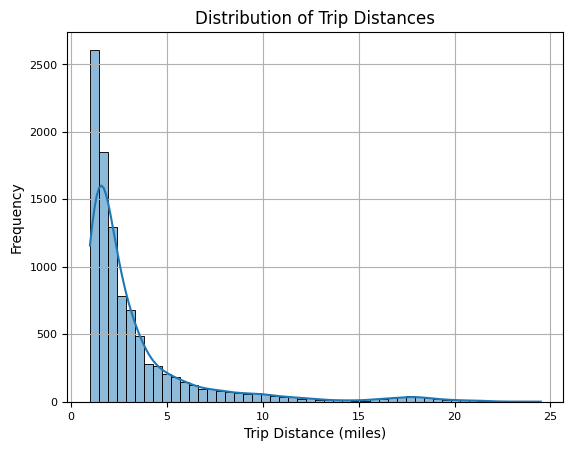

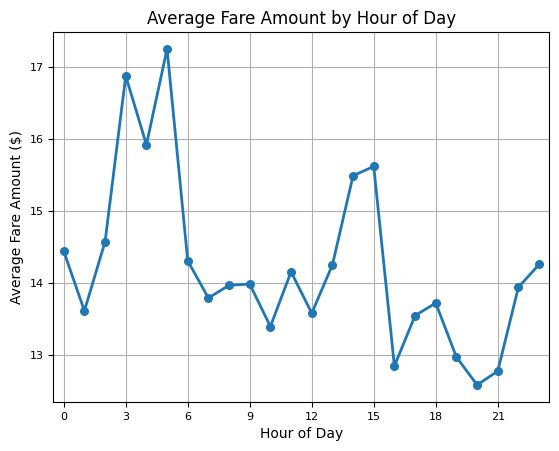

In [93]:
pandas_df = df.select("trip_distance", "fare_amount", "tpep_pickup_datetime").limit(10000).toPandas()

# a) distribution plot of trip distances
pandas_df['trip_distance'] = pd.to_numeric(pandas_df['trip_distance'], errors='coerce')
pandas_df = pandas_df.dropna(subset=['trip_distance'])
filtered_df = pandas_df[pandas_df['trip_distance'] <= 25]

ax = sns.histplot(data=filtered_df, x='trip_distance', bins=50, kde=True)

plt.title('Distribution of Trip Distances', fontsize=12)
plt.xlabel('Trip Distance (miles)', fontsize=10) 
plt.ylabel('Frequency', fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.grid(True)
plt.show()

# b) average fares by hour of day
pandas_df['tpep_pickup_datetime'] = pd.to_datetime(pandas_df['tpep_pickup_datetime'])
pandas_df['fare_amount'] = pd.to_numeric(pandas_df['fare_amount'], errors='coerce')
pandas_df['hour'] = pandas_df['tpep_pickup_datetime'].dt.hour
avg_fph = pandas_df.groupby('hour')['fare_amount'].mean().reset_index()
avg_fph.columns = ['Hour of Day', 'Average Fare Amount']

sns.pointplot(data=avg_fph, x='Hour of Day', y='Average Fare Amount', marker='o',
                  linewidth=2, markersize=5)

plt.title('Average Fare Amount by Hour of Day', fontsize=12)
plt.xlabel('Hour of Day', fontsize=10)
plt.ylabel('Average Fare Amount ($)', fontsize=10)

plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True)
plt.show()

In [ ]:
pandas_df = df.select("trip_distance", "fare_amount", "tpep_pickup_datetime").limit(10000).toPandas()

# a) distribution plot of trip distances
pandas_df['trip_distance'] = pd.to_numeric(pandas_df['trip_distance'], errors='coerce')
pandas_df = pandas_df.dropna(subset=['trip_distance'])
filtered_df = pandas_df[pandas_df['trip_distance'] <= 25]

ax = sns.histplot(data=filtered_df, x='trip_distance', bins=50, kde=True)

plt.title('Distribution of Trip Distances', fontsize=14)
plt.xlabel('Trip Distance (miles)', fontsize=10) 
plt.ylabel('Frequency', fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(rotation=45, fontsize=8)

plt.grid(True)
plt.show()

# b) average fares by hour of day
pandas_df['tpep_pickup_datetime'] = pd.to_datetime(pandas_df['tpep_pickup_datetime'])
pandas_df['fare_amount'] = pd.to_numeric(pandas_df['fare_amount'], errors='coerce')
pandas_df['hour'] = pandas_df['tpep_pickup_datetime'].dt.hour

avg_fph = pandas_df.groupby('hour')['fare_amount'].mean().reset_index()
avg_fph.columns = ['Hour of Day', 'Average Fare Amount']


sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Average Fare Amount ($)'})

plt.title('Average Fare Amount by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=10)
plt.ylabel('Average Fare Amount ($)', fontsize=10)
plt.xticks(rotation=45)

plt.grid(True)
plt.show()